In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import os
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

data_folder = Path("../../data")

# Necessary for notebook to see src package
import sys
sys.path.append('../..')

Device: cuda


# Download Dataset into Memory

In [16]:
dataset = pd.read_csv(data_folder / 'Intrusion' / 'data.csv')
dataset.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class
0,0,tcp,private,S0,0,0,0,0,0,0,...,9,0.04,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
1,0,tcp,pop_3,S0,0,0,0,0,0,0,...,25,0.10,0.05,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
2,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
3,0,tcp,private,S0,0,0,0,0,0,0,...,19,0.07,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
4,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
5,0,tcp,http,SF,313,4017,0,0,0,0,...,255,1.00,0.00,0.01,0.04,0.0,0.0,0.0,0.0,normal.
6,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
7,3,tcp,smtp,SF,840,331,0,0,0,0,...,142,0.57,0.03,0.01,0.01,0.0,0.0,0.0,0.0,normal.
8,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
9,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.


# Missing Values

There is no missing values in CTABGAN+ datasets but i am just making sure

In [17]:
print(f'Missing values in the dataset: {dataset.isna().sum().sum()}')

Missing values in the dataset: 0


# General Info

- Column `education-num` had the same info as the `education` column so it was safe an beneficial to drop that column 
- We can see that the columns _workclass_, _education_, _marital-status_, _occupation_, _relationship_, _race_, _gender_, _native-country_, _income_ are categorical variables.

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     49999 non-null  int64  
 1   protocol_type                49999 non-null  object 
 2   service                      49999 non-null  object 
 3   flag                         49999 non-null  object 
 4   src_bytes                    49999 non-null  int64  
 5   dst_bytes                    49999 non-null  int64  
 6   land                         49999 non-null  int64  
 7   wrong_fragment               49999 non-null  int64  
 8   urgent                       49999 non-null  int64  
 9   hot                          49999 non-null  int64  
 10  num_failed_logins            49999 non-null  int64  
 11  logged_in                    49999 non-null  int64  
 12  num_compromised              49999 non-null  int64  
 13  root_shell      

In [19]:
string_columns = [col for col in dataset.columns if dataset[col].dtype == 'object']
other_columns = [col for col in dataset.columns if col not in string_columns]

print(f'String cols: {string_columns}')
print(f'Other cols: {other_columns}')

String cols: ['protocol_type', 'service', 'flag', 'Class']
Other cols: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


# Categorical and Numerical Values

In [20]:
binary_columns = [col for col in other_columns if dataset[col].unique().__len__() <= 2]
multi_class_columns = [col for col in other_columns if (dataset[col].unique().__len__() > 2) and (dataset[col].unique().__len__() <= 20) ]
numeric_columns = [col for col in other_columns if col not in binary_columns and col not in multi_class_columns]

binary_columns = binary_columns + [col for col in string_columns if dataset[col].unique().__len__() <= 2]
multi_class_columns = multi_class_columns + [col for col in string_columns if (dataset[col].unique().__len__() > 2)]

print(f'binary_columns({len(binary_columns)}): {binary_columns}')
print(f'multi_class_columns({len(multi_class_columns)}): {multi_class_columns}')
print(f'numeric_columns({len(numeric_columns)}): {numeric_columns}')

binary_columns(9): ['land', 'urgent', 'num_failed_logins', 'logged_in', 'root_shell', 'num_shells', 'num_outbound_cmds', 'is_host_login', 'is_guest_login']
multi_class_columns(11): ['wrong_fragment', 'hot', 'num_compromised', 'su_attempted', 'num_root', 'num_file_creations', 'num_access_files', 'protocol_type', 'service', 'flag', 'Class']
numeric_columns(22): ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


# Other Columns and Their Cardinalities

In [21]:
for col in other_columns:
    print(f'{col:<20}: {dataset[col].dtype}({dataset[col].unique().__len__()})')

duration            : int64(401)
src_bytes           : int64(1201)
dst_bytes           : int64(3217)
land                : int64(1)
wrong_fragment      : int64(3)
urgent              : int64(1)
hot                 : int64(13)
num_failed_logins   : int64(2)
logged_in           : int64(2)
num_compromised     : int64(4)
root_shell          : int64(2)
su_attempted        : int64(3)
num_root            : int64(8)
num_file_creations  : int64(3)
num_shells          : int64(2)
num_access_files    : int64(3)
num_outbound_cmds   : int64(1)
is_host_login       : int64(1)
is_guest_login      : int64(2)
count               : int64(406)
srv_count           : int64(277)
serror_rate         : float64(42)
srv_serror_rate     : float64(28)
rerror_rate         : float64(50)
srv_rerror_rate     : float64(24)
same_srv_rate       : float64(70)
diff_srv_rate       : float64(55)
srv_diff_host_rate  : float64(54)
dst_host_count      : int64(255)
dst_host_srv_count  : int64(255)
dst_host_same_srv_rate: float64(

# Single Mode Gaussian Variables 

Here we can see that `age` is a single mode Gaussion variable

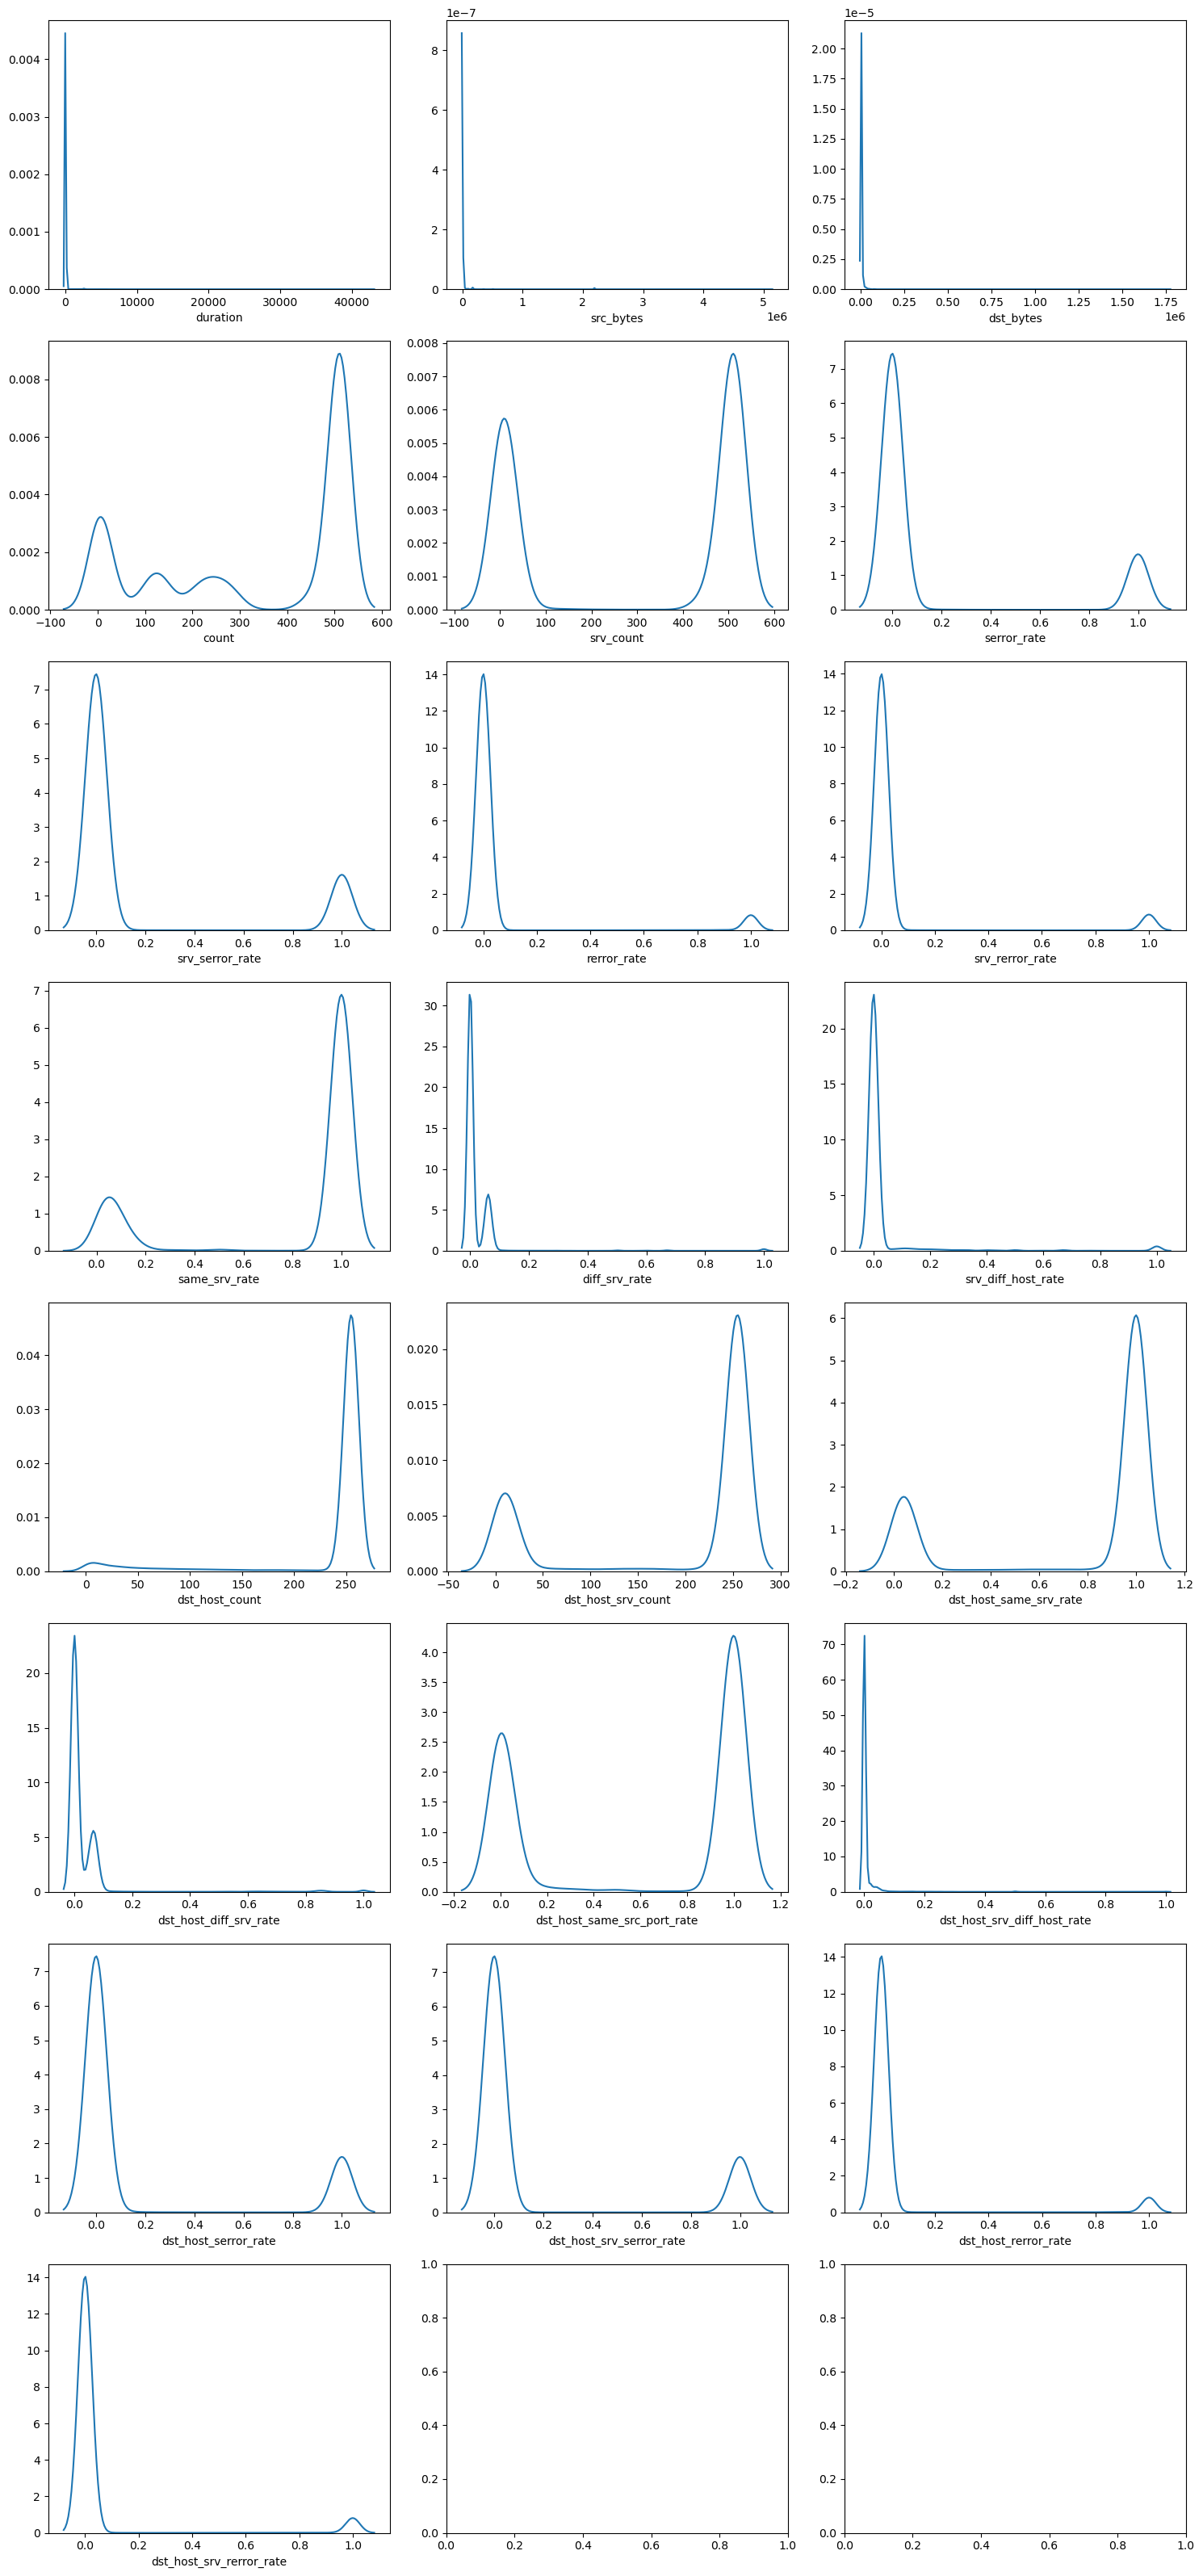

In [22]:
import math
from matplotlib.axes import Axes

fig = plt.figure(figsize=(15, math.ceil(len(numeric_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(numeric_columns) / 3.0), ncols=3)

for col_index in range(len(numeric_columns)):
    current_ax: Axes = ax[math.floor(col_index / 3.0)][col_index % 3]
    sns.kdeplot(
        data=dataset[numeric_columns[col_index]],
        ax=current_ax,
        common_norm=False,
    )
    current_ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Mixed Type Variables

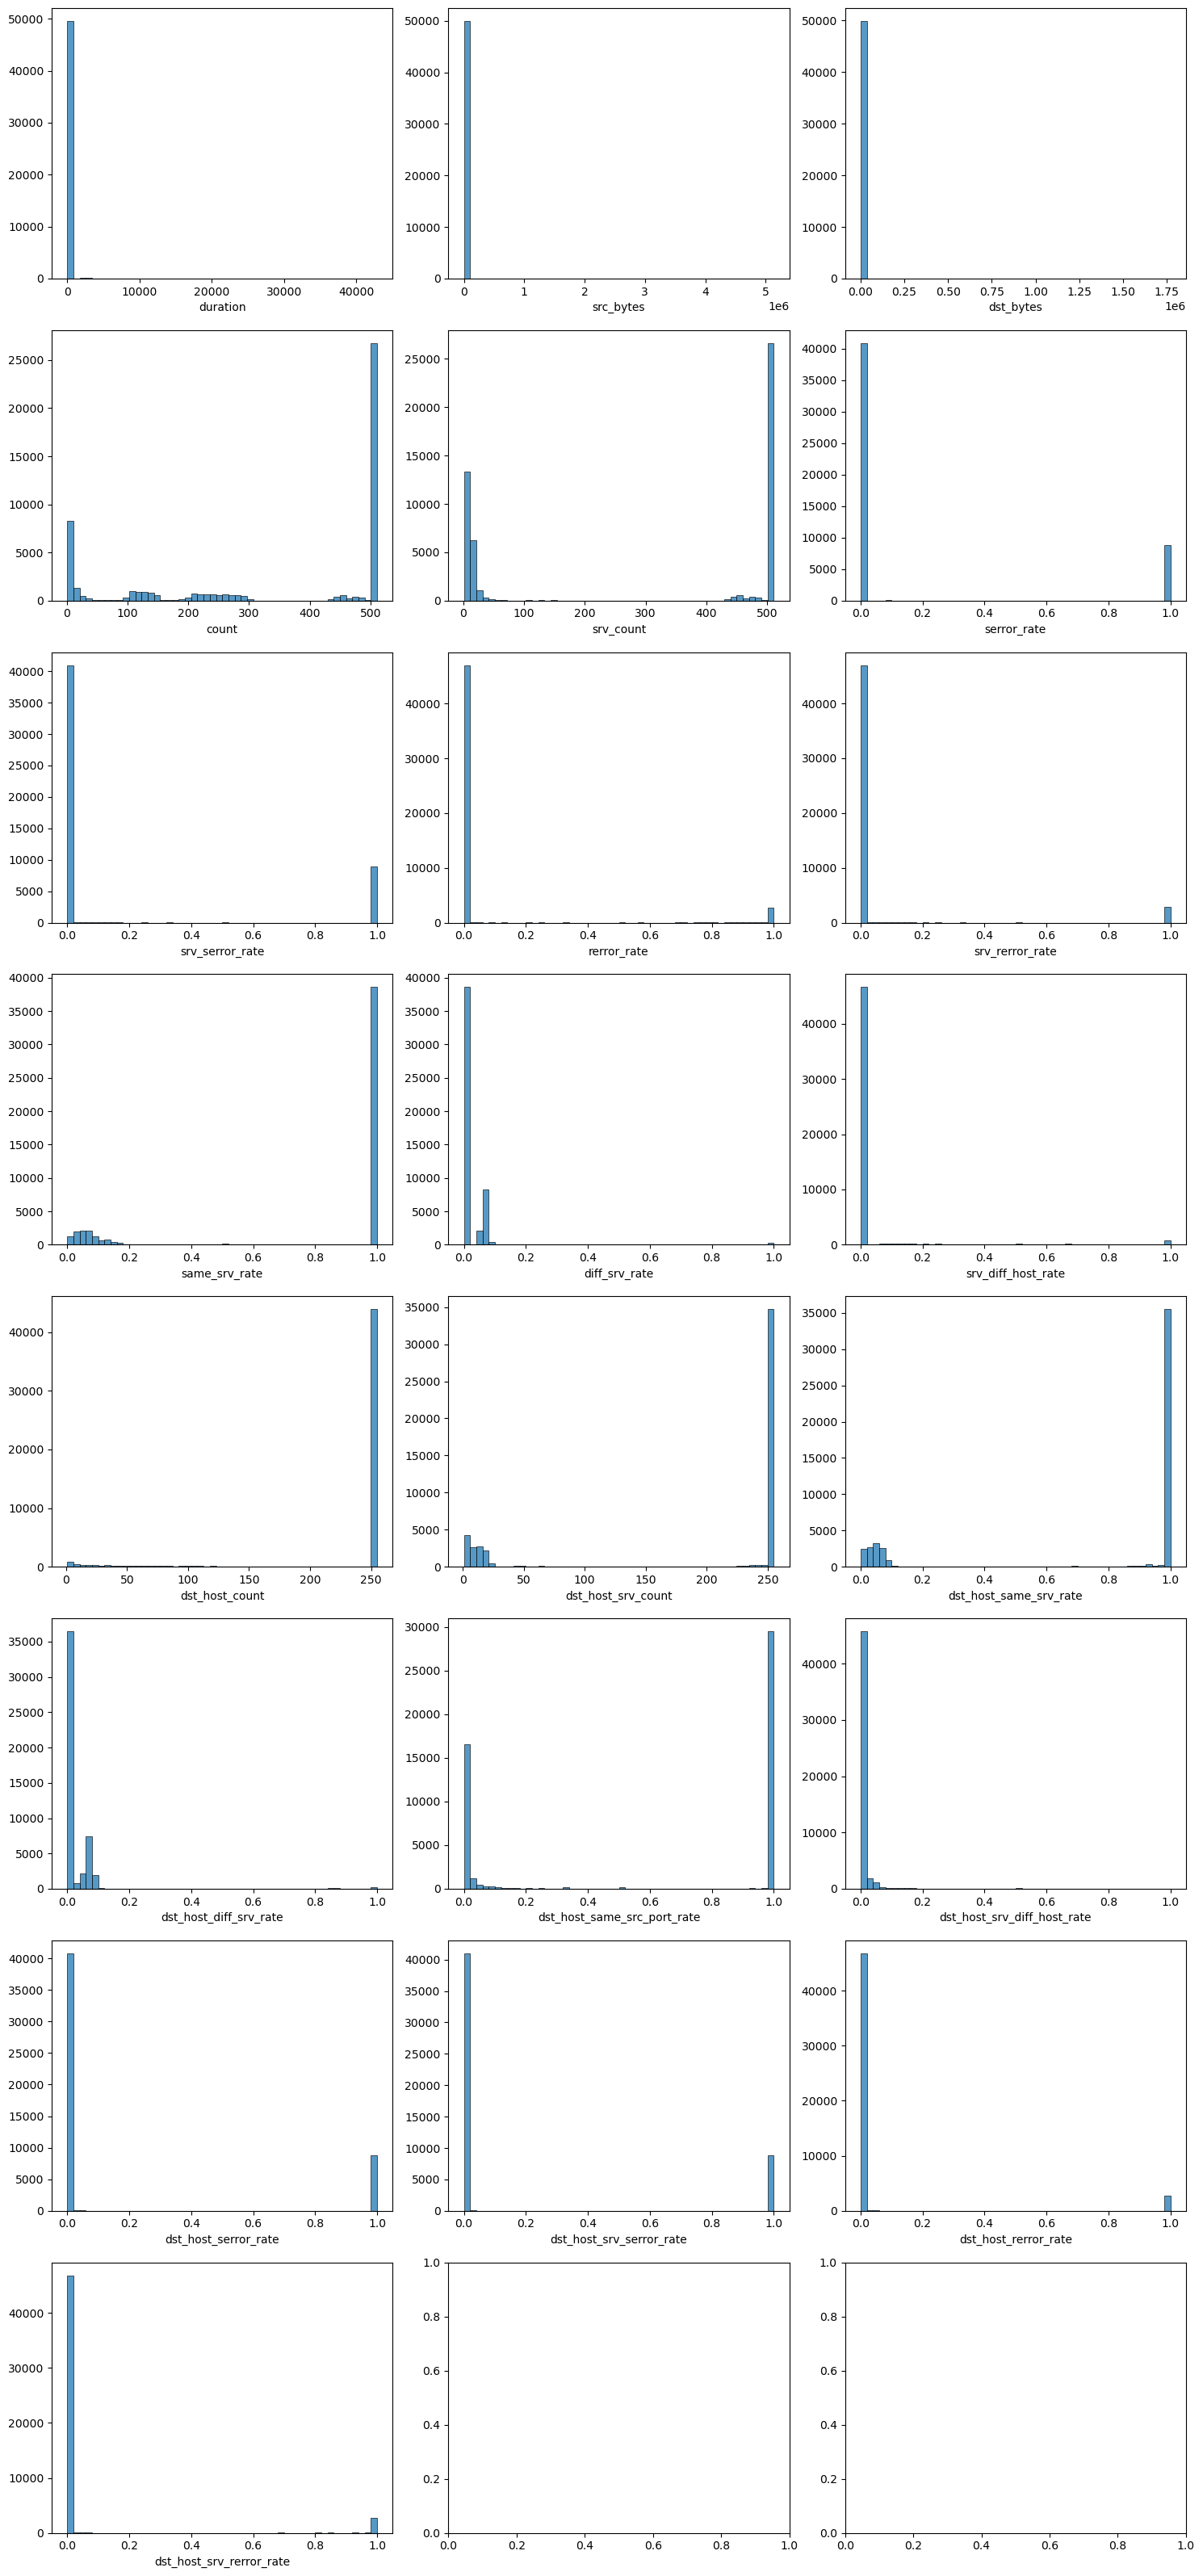

In [23]:
import math
from matplotlib.axes import Axes

fig = plt.figure(figsize=(15, math.ceil(len(numeric_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(numeric_columns) / 3.0), ncols=3)

for col_index in range(len(numeric_columns)):
    current_ax: Axes = ax[math.floor(col_index / 3.0)][col_index % 3]
    sns.histplot(
        data=dataset[numeric_columns[col_index]],
        ax=current_ax,
        bins=50
    )
    current_ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Categorical Variables

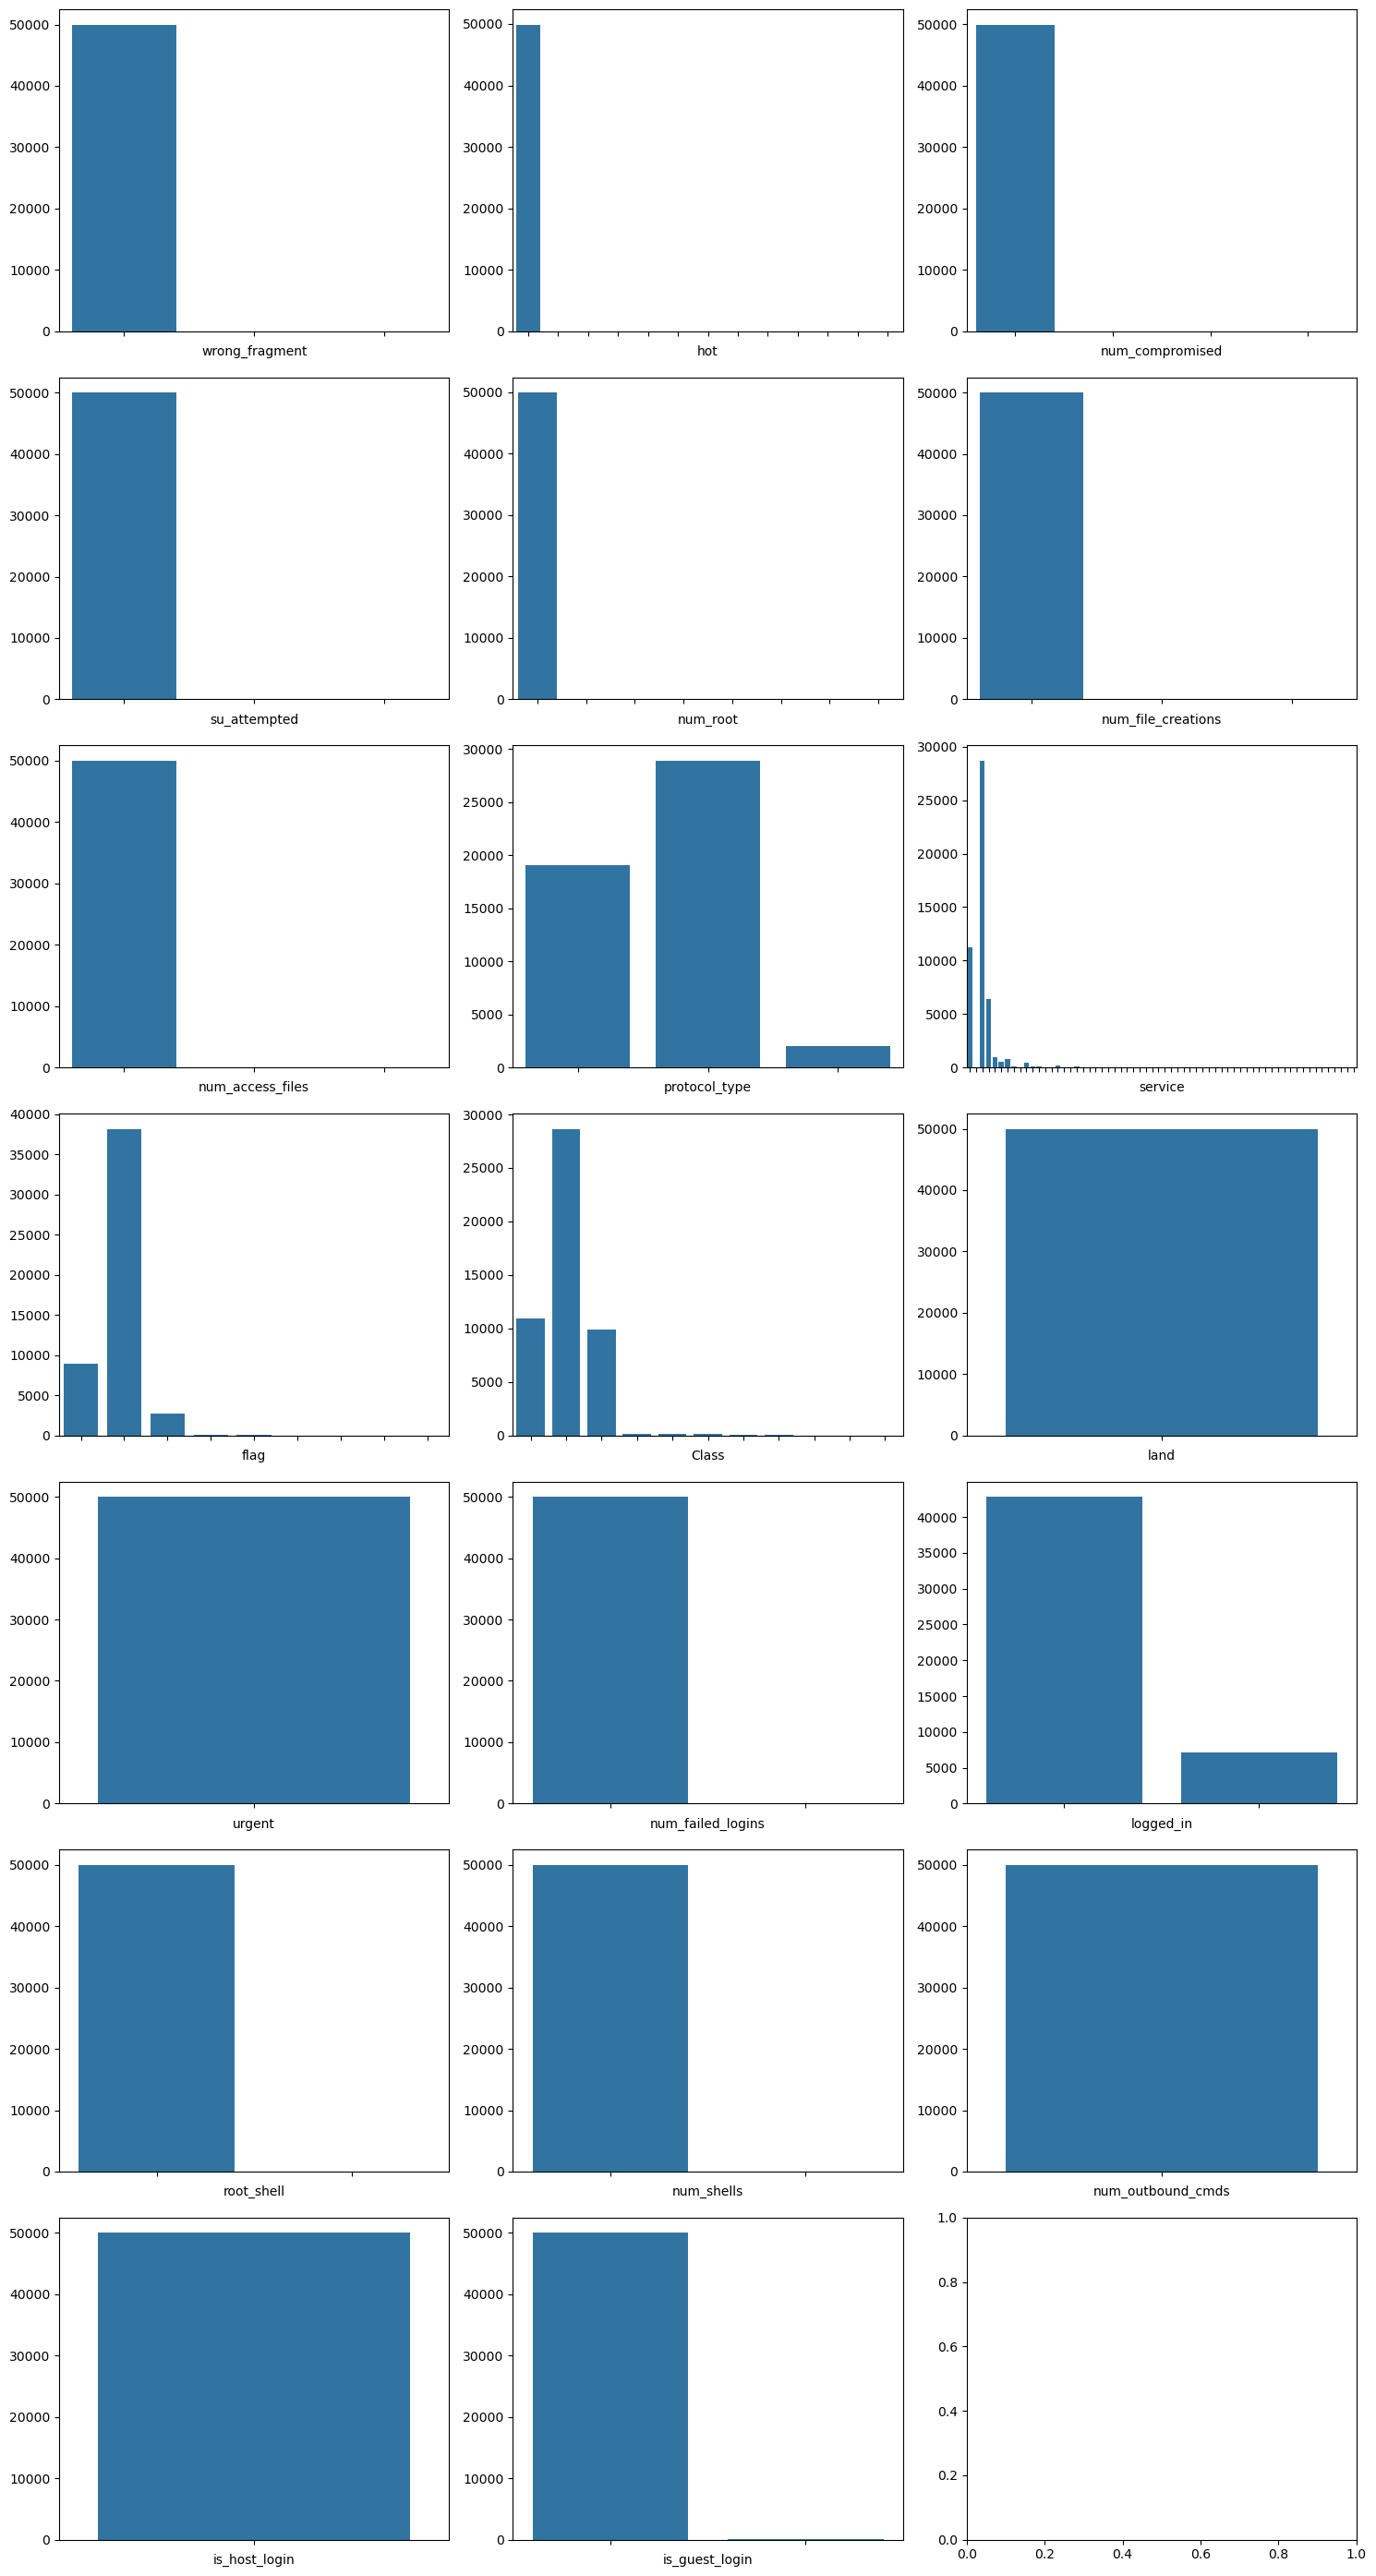

In [24]:
import math
from matplotlib.axes import Axes

categorical_columns = multi_class_columns + binary_columns

fig = plt.figure(figsize=(15, math.ceil(len(categorical_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(categorical_columns) / 3.0), ncols=3)

for col_index in range(len(categorical_columns)):
    current_ax: Axes = ax[math.floor(col_index / 3.0)][col_index % 3]
    sns.countplot(
        data=dataset,
        x=categorical_columns[col_index],
        ax=current_ax,
    )
    current_ax.set_ylabel('')
    current_ax.set_xticklabels([])
plt.tight_layout()
plt.show()

In [25]:
len(categorical_columns)

20

In [26]:
len(numeric_columns)

22

In [27]:
for col in numeric_columns:
    print(f'{col:<20}: {dataset[col].dtype}({dataset[col].unique().__len__()})')

duration            : int64(401)
src_bytes           : int64(1201)
dst_bytes           : int64(3217)
count               : int64(406)
srv_count           : int64(277)
serror_rate         : float64(42)
srv_serror_rate     : float64(28)
rerror_rate         : float64(50)
srv_rerror_rate     : float64(24)
same_srv_rate       : float64(70)
diff_srv_rate       : float64(55)
srv_diff_host_rate  : float64(54)
dst_host_count      : int64(255)
dst_host_srv_count  : int64(255)
dst_host_same_srv_rate: float64(101)
dst_host_diff_srv_rate: float64(97)
dst_host_same_src_port_rate: float64(100)
dst_host_srv_diff_host_rate: float64(52)
dst_host_serror_rate: float64(56)
dst_host_srv_serror_rate: float64(21)
dst_host_rerror_rate: float64(96)
dst_host_srv_rerror_rate: float64(84)


# Long Tail Columns

In [37]:


print(f'Median: \n{dataset[['dst_bytes', 'src_bytes']].median()}')
print(f'Average: \n{dataset[['dst_bytes', 'src_bytes']].mean()}')
print(f'Max: \n{dataset[['dst_bytes', 'src_bytes']].max()}')

Median: 
dst_bytes      0.0
src_bytes    520.0
dtype: float64
Average: 
dst_bytes    678.112722
src_bytes    916.231065
dtype: float64
Max: 
dst_bytes    1770818
src_bytes    5135678
dtype: int64


The final argumnets for the dataset is:

In [38]:
import json

args = {
    'categorical_columns' :categorical_columns,
    'log_columns': ['dst_bytes', 'src_bytes'],
    'mixed_columns': {}, # Mixed Types
    'general_columns': [],                                 # Single Gaussian Mode or Highly cardinal data
    'non_categorical_columns': [],
    'integer_columns': [col for col in numeric_columns if dataset[col].dtype=='int'],
    'problem_type': 'classification',
    'target': 'Class'
}

with open(data_folder / 'Intrusion' / 'metadata.json', 'w+') as file:
    json.dump(args, file, indent=4)

In [29]:
args

{'categorical_columns': ['wrong_fragment',
  'hot',
  'num_compromised',
  'su_attempted',
  'num_root',
  'num_file_creations',
  'num_access_files',
  'protocol_type',
  'service',
  'flag',
  'Class',
  'land',
  'urgent',
  'num_failed_logins',
  'logged_in',
  'root_shell',
  'num_shells',
  'num_outbound_cmds',
  'is_host_login',
  'is_guest_login'],
 'log_columns': [],
 'mixed_columns': {},
 'general_columns': ['bmi'],
 'non_categorical_columns': [],
 'integer_columns': ['duration',
  'src_bytes',
  'dst_bytes',
  'count',
  'srv_count',
  'dst_host_count',
  'dst_host_srv_count'],
 'problem_type': 'regression',
 'target': 'charges'}